In [1]:
# !pip install markdown

In [2]:

# --- Technical Setup ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import Dict, List, Optional, Tuple

# Ignore warnings for a cleaner executive report
warnings.filterwarnings('ignore')

# Set plotting style and display options
sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
print("✅ Setup complete.")

✅ Setup complete.


In [3]:
# --- Corrected Cell 1: Imports ---

# Explicitly import all the necessary components from your .py file
from capacity_pipeline import (
    ColumnMap, ScoreConfig, WSIConfig, ScenarioConfig, OptimizeConfig,
    DataPrep, CapacityScorer, WSIComputer, OutcomeModeler, ScenarioEngine, Optimizer,
    make_sample_data,
    plot_score_distributions, plot_team_metrics, plot_feature_importances,
    plot_contributions_waterfall, plot_simulation_heatmap, plot_optimization_plan,
    plot_simulation_distributions, plot_bucket_uplift_distributions,
    plot_volume_uplift_distributions
)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import Dict, List, Optional, Tuple

# Ignore warnings for a cleaner executive report
warnings.filterwarnings('ignore')

# Set plotting style and display options
sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
print("✅ Setup complete with all components imported.")

✅ Setup complete with all components imported.


In [ ]:
# --- Unified & Final Configuration for Your Data ---
import pandas as pd

# 1. DEFINE YOUR FEATURES AND THEIR DIRECTION
# These are the specific features from your dataset that the model will use.
capacity_features = [
    "numCases", "numOpenCases", "backlog", "TimeSpent", "ScheduleBlocks", "numCritsit", "sumIsCritsit",
    "currentSev1", "currentSevA", "currentSevB", "currentSevC", "initialSev1", "initialSevA",
    "initialSevB", "initialSevC", "maxSev1", "maxSevA", "maxSevB", "maxSevC", "WasEverSev1A",
    "avgServiceRequestOwnershipCount", "OwnershipCount", "TaskCount", "TotalEvent", "avgDaysToClose",
    "avgHoursToInitialResponse", "Is24X7OptedIn", "num24X7OptedIn", "IsClosedOnWeekend", "LinearityScore",
    "AICS", "tenure", "som", "activeTimeRatio", "hoursToSLAExpires", "IsIRMet", "incidentServiceRequestType",
    "nonIncidentServiceRequestType", "unknownServiceRequestType", "IsARR", "IsEnterpriseSupport",
    "SAPs", "CrossSAPTasks", "hasICM", "ICM_flag",
]

# The direction map for your features (True = higher is worse, False = higher is better).
FEATURE_DIRECTION = {
    "numCases": True, "numOpenCases": True, "backlog": True, "TimeSpent": True, "ScheduleBlocks": True,
    "numCritsit": True, "sumIsCritsit": True, "currentSev1": True, "currentSevA": True, "currentSevB": True, "currentSevC": True,
    "initialSev1": True, "initialSevA": True, "initialSevB": True, "initialSevC": True, "maxSev1": True, "maxSevA": True,
    "maxSevB": True, "maxSevC": True, "WasEverSev1A": True, "avgServiceRequestOwnershipCount": True, "OwnershipCount": True,
    "TaskCount": True, "TotalEvent": True, "avgDaysToClose": True, "avgHoursToInitialResponse": True,
    "Is24X7OptedIn": True, "num24X7OptedIn": True, "IsClosedOnWeekend": True, "LinearityScore": False, "AICS": False,
    "tenure": False, "som": False, "activeTimeRatio": True, "hoursToSLAExpires": False, "IsIRMet": False,
    "incidentServiceRequestType": True, "nonIncidentServiceRequestType": True, "unknownServiceRequestType": True,
    "IsARR": True, "IsEnterpriseSupport": True, "SAPs": True, "CrossSAPTasks": True, "hasICM": True, "ICM_flag": True,
}

# 2. CONFIGURE THE PIPELINE COMPONENTS
# Defines the main identifier columns. The defaults match your data.
cols = ColumnMap()

# Config for the Capacity Score model
score_cfg = ScoreConfig(
    method="DSLI",
    direction_map=FEATURE_DIRECTION,  # IMPORTANT: Use your custom direction map
    random_state=42
)

# Config for the Workload Stress Index (WSI)
wsi_cfg = WSIConfig(team_aggregate="mean")

# Config for "What-If" Scenarios
scn_cfg = ScenarioConfig(random_state=42)

# Config for the Optimizer
opt_cfg = OptimizeConfig(
    budget_moves=15,
    objective_weights={
        'WSI_0_100': -1.0,
        'efficiency': +0.6,
        'days_to_close': -0.6,
        'backlog': -0.8,
        'numCases': +0.25
    },
    random_state=42
)

print("✅ Configuration loaded with your custom features.")

In [6]:
# --- Corrected Cell: Load YOUR Data and Calculate Scores ---

# NOTE: This cell assumes your DataFrame 'df_in' is already loaded in a previous cell.
# We create a copy to avoid modifying your original data.
df_full = df_in.copy()

# The pipeline uses standardized names 'efficiency' and 'days_to_close'.
# These lines create them from your 'som' and 'avgDaysToClose' columns.
df_full['efficiency'] = df_full['som']
df_full['days_to_close'] = df_full['avgDaysToClose']

# 1. Prepare the data (calculates deviations from team benchmarks)
# FIX: Pass your full list of features to the DataPrep class
prep = DataPrep(columns=cols, features=capacity_features, config=score_cfg).fit(df_full)
df_prepped = prep.transform(df_full)

# 2. Calculate the 0-100 Capacity Score for each employee-month
scorer = CapacityScorer(config=score_cfg).fit(df_prepped, group_col=cols.group, id_cols=(cols.alias, cols.date))
scores = scorer.transform(df_prepped, group_col=cols.group, id_cols=(cols.alias, cols.date))

# Merge the new score column back into the main dataframe
df_scored = df_full.merge(
    scores[[cols.alias, cols.date, 'Capacity_Score_0_100']],
    on=[cols.alias, cols.date],
    how="left"
)

# 4. Calculate the 0-100 WSI and aggregate for teams
wsi_computer = WSIComputer(columns=cols, config=wsi_cfg)
wsi_results = wsi_computer.compute(df_scored)
alias_metrics = wsi_results["alias_metrics"]
team_metrics = wsi_results["team_metrics"]

print("✅ All scores calculated successfully using your data.")
display(alias_metrics.head())

✅ All scores calculated successfully.


,alias,StaffGroup,_date_,Capacity_Score_0_100,WSI_0_100,_cap_dev,_persist,_complex,_time
0,SG-A-E01,SG-A,2025-06-01,0.00,2.10,0.00,0.00,0.13,0.00
1,SG-A-E01,SG-A,2025-07-01,3.73,5.31,0.00,0.00,0.20,0.00
2,SG-A-E01,SG-A,2025-08-01,0.00,4.26,0.00,0.00,0.18,0.00
3,SG-A-E02,SG-A,2025-06-01,100.00,7.54,0.00,0.12,0.12,0.00
4,SG-A-E02,SG-A,2025-07-01,100.00,15.10,0.00,0.25,0.17,0.00


--- How are our employees distributed across these scores? (Latest Month) ---
✅ Plot saved to: score_distributions.png


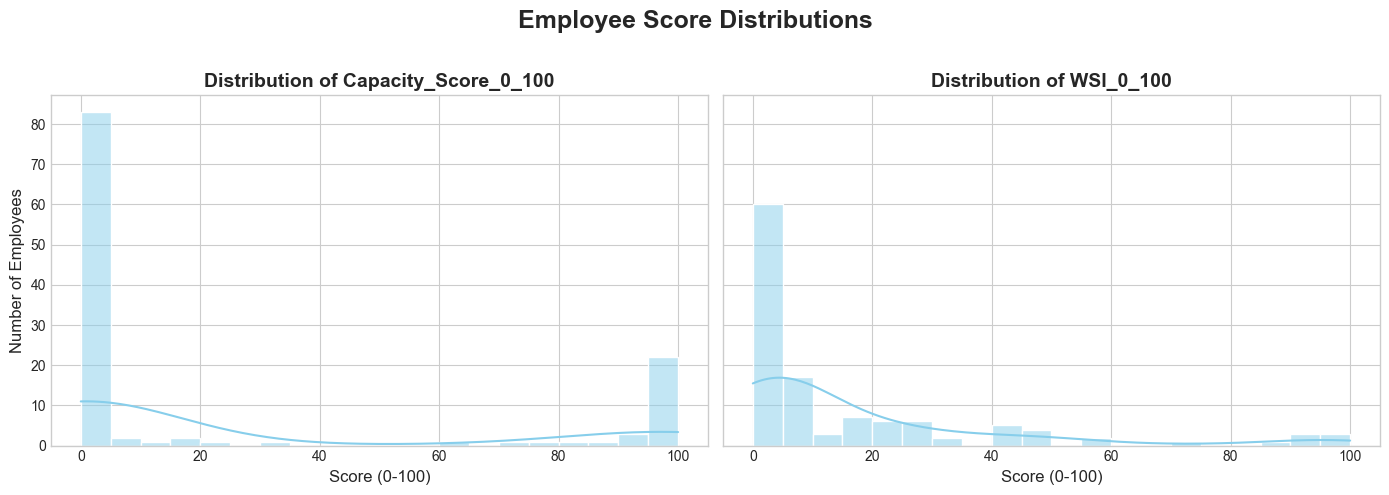


--- How do the teams compare on key WSI components over time? ---
Note: 'Capacity Deviation' now shows positive (above baseline) and negative (below baseline) performance.
✅ Plot saved to: team_metrics_over_time.png


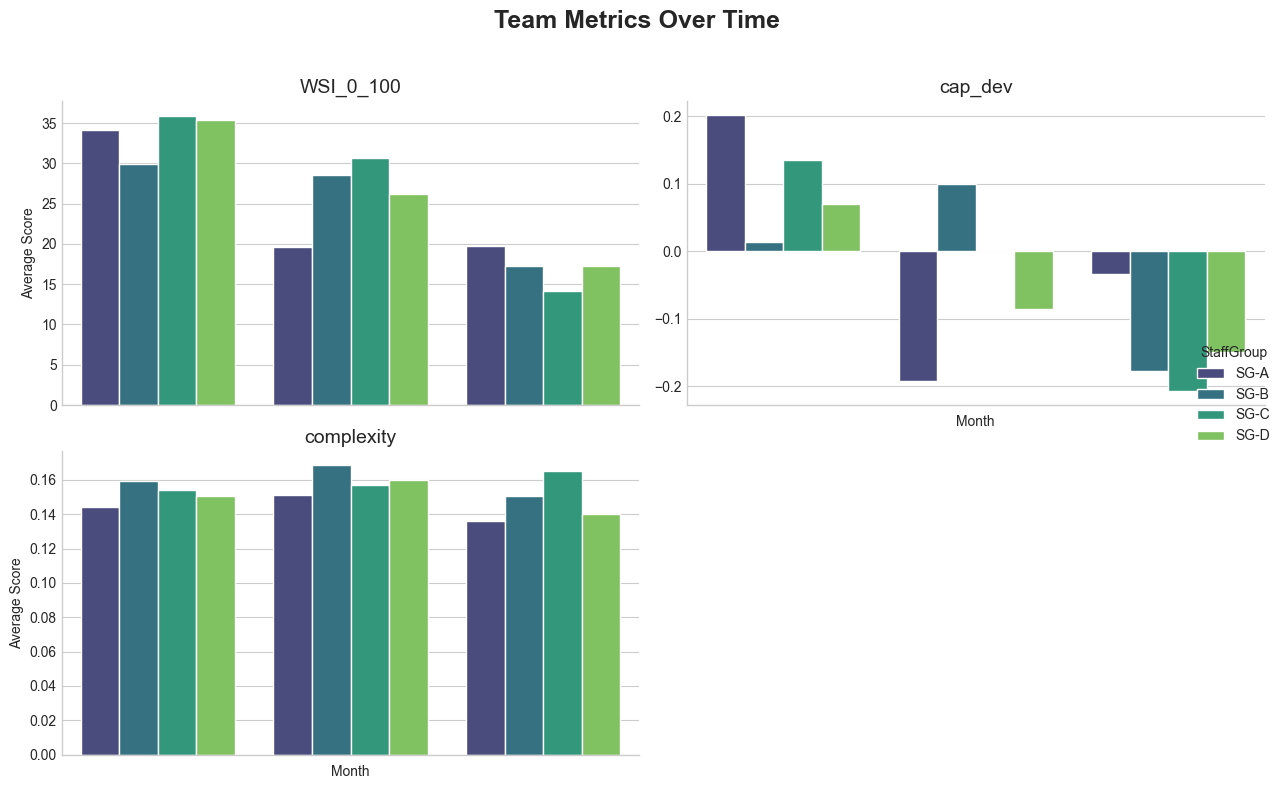

In [7]:
# --- Corrected Cell 5: ❓ Question 1: What are the Capacity Score & WSI? ---

# The Capacity Score (0-100) measures an employee's overall operational performance. A higher score is better.
# The Workload Stress Index (WSI) (0-100) measures workload pressure. A higher score indicates more stress.

# This dictionary will store the paths to all our saved plots.
saved_plots = {}

print("--- How are our employees distributed across these scores? (Latest Month) ---")
latest_month_df = alias_metrics[alias_metrics['_date_'] == alias_metrics['_date_'].max()]

# Define a path and save the plot
score_dist_path = "score_distributions.png"
plot_score_distributions(latest_month_df, ['Capacity_Score_0_100', 'WSI_0_100'], save_path=score_dist_path)
saved_plots["[INSERT SCORE DISTRIBUTION PLOT HERE]"] = score_dist_path


print("\n--- How do the teams compare on key WSI components over time? ---")
print("Note: 'Capacity Deviation' now shows positive (above baseline) and negative (below baseline) performance.")

# Define a path and save the plot
team_metrics_path = "team_metrics_over_time.png"
plot_team_metrics(team_metrics, ['WSI_0_100', 'cap_dev', 'complexity'], save_path=team_metrics_path)
saved_plots["[INSERT TEAM METRICS PLOT HERE]"] = team_metrics_path

--- Global Drivers: What factors matter most across the organization? ---
✅ Plot saved to: feature_importance.png


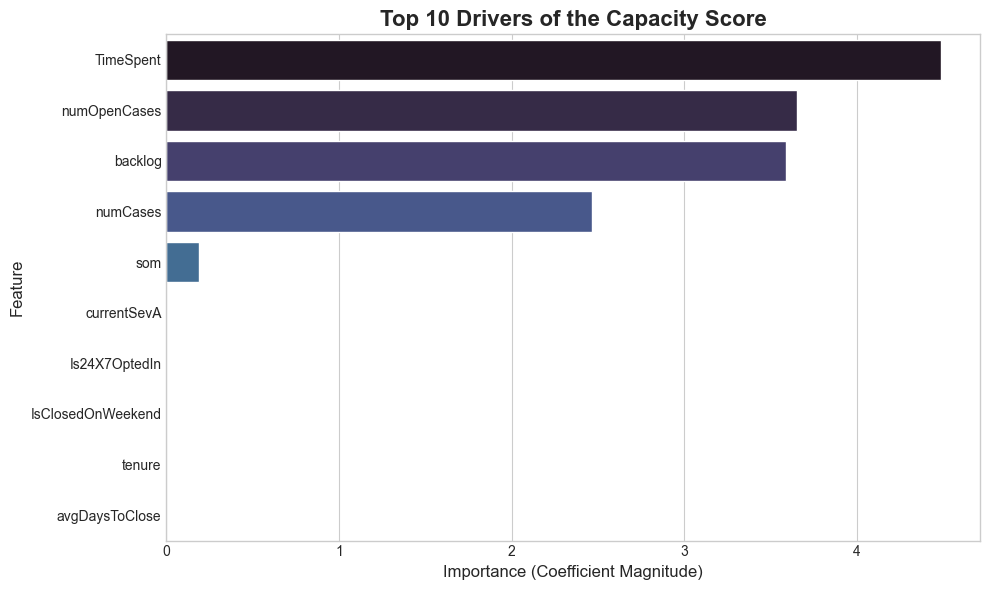


--- Local Drivers: Why did a specific employee get their score? ---
✅ Plot saved to: contributions_waterfall.png


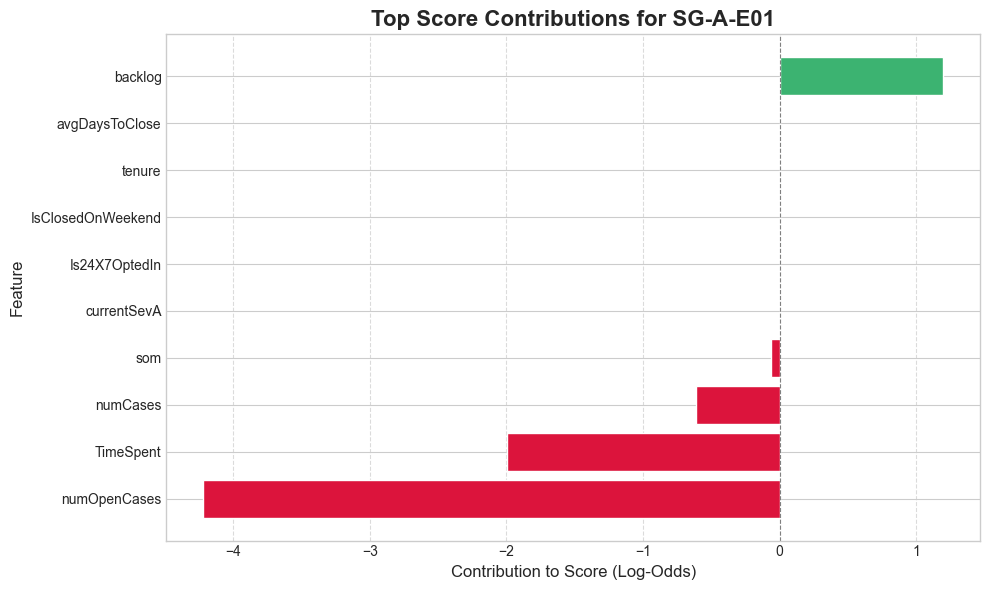

In [20]:
# print("--- Global Drivers: What factors matter most across the organization? ---")
# # This chart shows the factors with the highest overall impact on the Capacity Score.
# # A higher bar means the feature is more influential in determining the score.
# plot_feature_importances(scorer)

# print("\n--- Local Drivers: Why did a specific employee get their score? ---")
# # This waterfall chart breaks down the score for a single employee.
# # Green bars are factors that helped their score; red bars are factors that hurt it.
# example_employee = df_prepped.iloc[0]
# contributions = scorer.contributions(df_prepped, alias=example_employee[cols.alias], date=example_employee[cols.date])
# plot_contributions_waterfall(contributions, alias=example_employee[cols.alias])


# In Cell [7]
print("--- Global Drivers: What factors matter most across the organization? ---")
feature_importance_path = "feature_importance.png" # Define path
plot_feature_importances(scorer, save_path=feature_importance_path) # Add save_path

print("\n--- Local Drivers: Why did a specific employee get their score? ---")
example_employee = df_prepped.iloc[0]
contributions = scorer.contributions(df_prepped, alias=example_employee[cols.alias], date=example_employee[cols.date])
contributions_path = "contributions_waterfall.png" # Define path
plot_contributions_waterfall(contributions, alias=example_employee[cols.alias], save_path=contributions_path) # Add save_path

This tool simulates moving employees between teams to see the projected impact.

--- Simulation Results: Comparing 'Before' vs. 'After' ---
✅ Plot saved to: simulation_heatmap.png


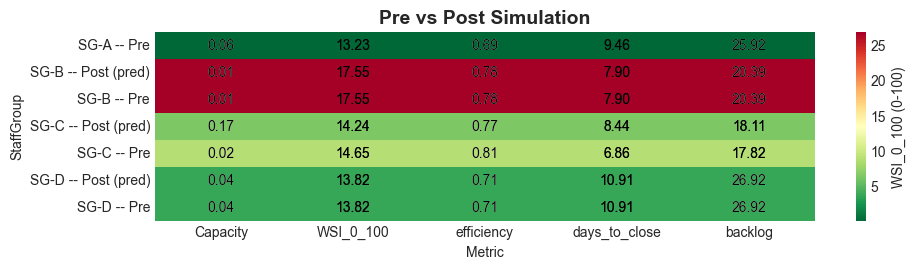

✅ Distribution plot saved to: simulation_distributions.png


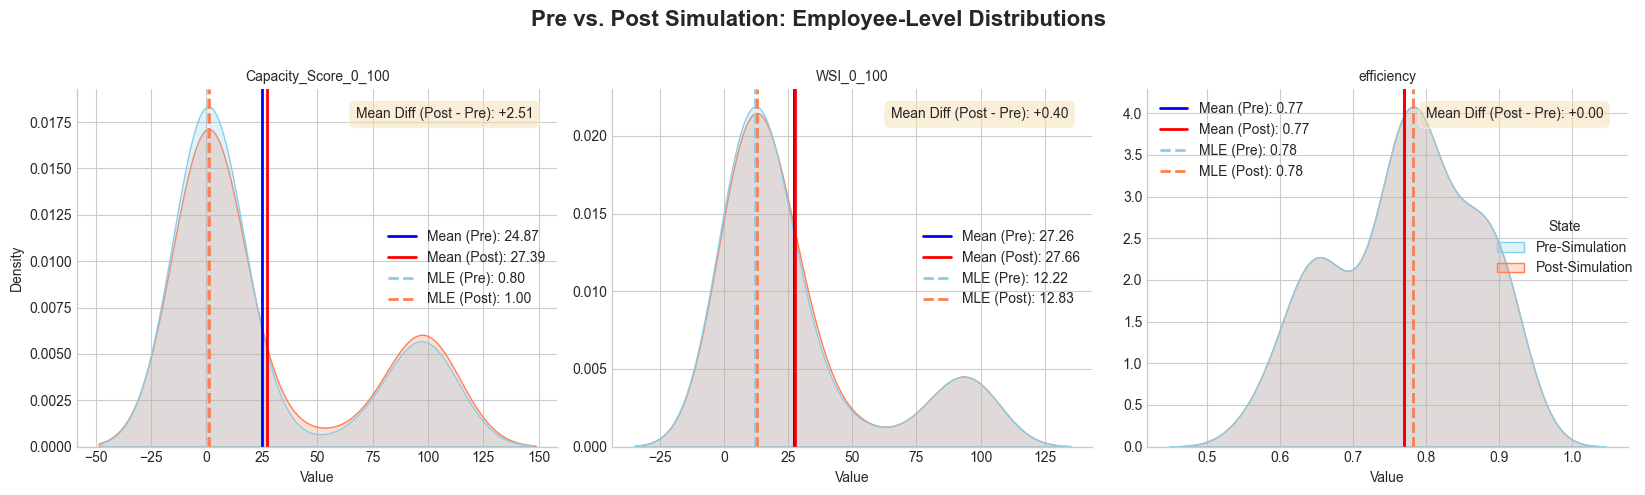


✅ Simulation plots saved successfully.


In [9]:
# --- Corrected Cell 7: ❓ Question 3: What-If Scenario - Simulating Headcount Moves ---
print("This tool simulates moving employees between teams to see the projected impact.")

# Define your hypothetical moves
moves = [
    {"from": "SG-A", "to": "SG-C", "n": 30}
]

# Run the simulation
df_month = df_full[df_full['_date_'] == df_full['_date_'].max()]
modeler = OutcomeModeler().fit(df_scored.dropna())
engine = ScenarioEngine(columns=cols, prep=prep, scorer=scorer, wsi=wsi_computer, modeler=modeler, config=scn_cfg)
sim_results = engine.simulate_moves(df_month, moves=moves)

print("\n--- Simulation Results: Comparing 'Before' vs. 'After' ---")
# This heatmap visualizes the projected state of each team before and after the move.
# The color is based on the WSI score (Green = Low Stress, Red = High Stress).
simulation_heatmap_path = "simulation_heatmap.png"

# FIX: Use the correct keys "pre_agg" and "post_agg" to access the dataframes
stacked_sim_data = plot_simulation_heatmap(
    sim_results["pre_agg"], 
    sim_results["post_agg"], 
    save_path=simulation_heatmap_path
)
saved_plots["[INSERT SIMULATION HEATMAP HERE]"] = simulation_heatmap_path

# NEW: Overlapping distribution plots for key metrics at the employee level
simulation_dist_path = "simulation_distributions.png"
plot_simulation_distributions(
    pre_df_employee=sim_results["pre_employee"],
    post_df_employee=sim_results["post_employee"],
    metrics=['Capacity_Score_0_100', 'WSI_0_100', 'efficiency'],
    save_path=simulation_dist_path
)
saved_plots["[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]"] = simulation_dist_path


print("\n✅ Simulation plots saved successfully.")

In [10]:
# --- Corrected Cell: 📈 Bucket Uplift Impact Analysis ---

print("This analysis estimates the incremental number of cases that could be handled by improving employee capacity.")
print("It calculates the impact of moving a percentage of employees from each performance bucket to the next one up.")

def run_bucket_uplift_analysis(
    alias_metrics_df: pd.DataFrame,
    cap_edges: List[float] = [0, 25, 50, 75, 100],
    pct_moves: List[float] = [0.10, 0.05, 0.02]  # Pct to move from bucket 1->2, 2->3, 3->4
):
    """
    Performs a rule-based incremental planning analysis based on capacity buckets.
    """
    df = alias_metrics_df.copy()
    cap_labels = [f"{int(cap_edges[i])}-{int(cap_edges[i+1])}" for i in range(len(cap_edges)-1)]
    
    # 1. Assign employees to capacity buckets
    df["bucket"] = pd.cut(
        df['Capacity_Score_0_100'],
        bins=cap_edges,
        labels=cap_labels,
        include_lowest=True
    )

    # 2. Calculate stats for each bucket
    stats = (df.groupby("bucket", observed=False)
               .agg(
                   aliases=("alias", "nunique"),
                   cap_median=("Capacity_Score_0_100", "median"),
                   wsi_median=("WSI_0_100", "median"),
                   eff_median=("efficiency", "median"),
                   nc_median=("numCases", "median")
               )
               .reindex(cap_labels)
               .reset_index())
    
    stats["pct"] = (stats["aliases"] / max(1, stats["aliases"].sum()) * 100).round(2)

    # 3. Calculate how many people are "moved in" to each bucket
    moved_counts = [0] # Bucket 1 has no one moving into it
    for i in range(len(pct_moves)):
        if i < len(stats):
            moved_count = int(np.floor((stats.loc[i, "aliases"] or 0) * pct_moves[i]))
            moved_counts.append(moved_count)
    
    # Ensure moved_counts has the same length as the number of buckets
    moved_counts = moved_counts[:len(stats)]
    stats["moved_in"] = moved_counts

    # 4. Calculate incremental cases for each bucket
    # This is: (people moved in) * (median cases of the destination bucket)
    inc_cases = [0.0] * len(stats)
    for i in range(1, len(stats)): # Start from the second bucket
        if pd.notna(stats.loc[i, "nc_median"]):
            inc_cases[i] = stats.loc[i, "moved_in"] * stats.loc[i, "nc_median"]
            
    stats["incremental_cases_bucket"] = inc_cases

    # 5. Create the total row
    total_row = pd.DataFrame([{
        "bucket": "TOTAL",
        "aliases": int(stats["aliases"].sum()),
        "pct": 100.0,
        "moved_in": int(stats["moved_in"].sum()),
        "incremental_cases_bucket": float(stats["incremental_cases_bucket"].sum())
    }])
    
    final_df = pd.concat([stats, total_row], ignore_index=True)
    return final_df

# --- Run the Analysis ---
# We use the latest month's data and the helper function from the pipeline to get the necessary metrics.
uplift_input_df = df_scored[df_scored['_date_'] == df_scored['_date_'].max()].merge(
    alias_metrics[['_date_', 'alias', 'WSI_0_100']], on=['_date_', 'alias']
)

# --- NEW: Define your custom move percentages here ---
# This list corresponds to the percentage of employees to move from:
# bucket 1->2, bucket 2->3, and bucket 3->4
custom_pct_moves = [0.15, 0.10, 0.05] # e.g., Move 15% from bucket 1, 10% from bucket 2, etc.

print(f"Running uplift analysis with custom move percentages: {custom_pct_moves}")
bucket_uplift_summary = run_bucket_uplift_analysis(
    uplift_input_df,
    pct_moves=custom_pct_moves # Pass the custom list to the function
)
display(bucket_uplift_summary)

This analysis estimates the incremental number of cases that could be handled by improving employee capacity.
It calculates the impact of moving a percentage of employees from each performance bucket to the next one up.
Running uplift analysis with custom move percentages: [0.15, 0.1, 0.05]


,bucket,aliases,cap_median,wsi_median,eff_median,nc_median,pct,moved_in,incremental_cases_bucket
0,0-25,89,0.00,3.82,0.76,36.00,74.17,0,0.00
1,25-50,1,30.24,2.20,0.89,46.00,0.83,13,598.00
2,50-75,2,69.48,91.46,0.70,43.00,1.67,0,0.00
3,75-100,28,99.70,23.23,0.85,52.00,23.33,0,0.00
4,TOTAL,120,NaN,NaN,NaN,NaN,100.00,13,598.00


This simulation shows the impact on the total 'numCases' distribution for all employees,
if a percentage of staff from lower buckets were uplifted to perform at the next level.
✅ Volume uplift plot saved to: total_volume_uplift_distribution.png


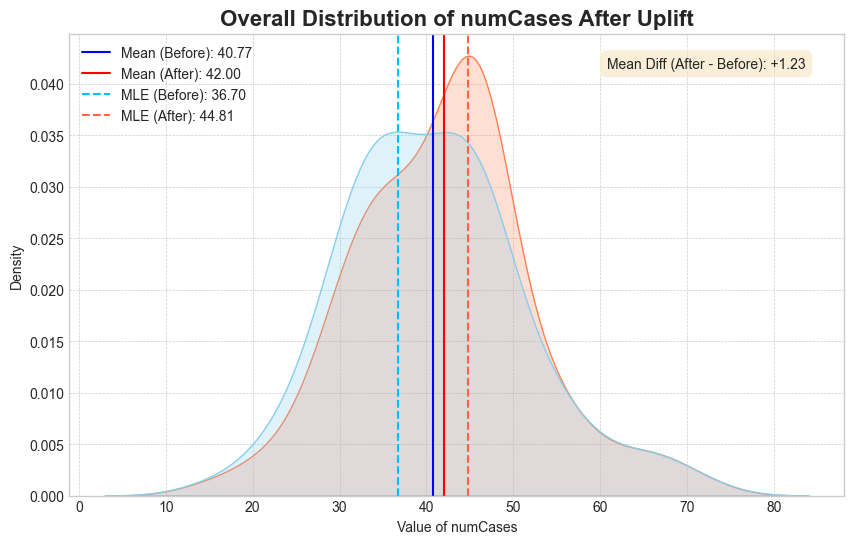

In [11]:
# --- 📈 NEW: Overall Volume Impact from Bucket Uplift ---

print("This simulation shows the impact on the total 'numCases' distribution for all employees,")
print("if a percentage of staff from lower buckets were uplifted to perform at the next level.")

def simulate_total_volume_uplift(
    alias_metrics_df: pd.DataFrame,
    cap_edges: List[float] = [0, 25, 50, 75, 100],
    pct_moves: List[float] = [0.15, 0.10, 0.05]
):
    """
    Simulates the change in the entire 'numCases' distribution by "moving"
    a percentage of employees from lower capacity buckets to higher ones.
    Returns the 'before' and 'after' dataframes for the whole population.
    """
    df = alias_metrics_df.copy()
    cap_labels = [f"{int(cap_edges[i])}-{int(cap_edges[i+1])}" for i in range(len(cap_edges)-1)]
    
    # Create the 'before' state (which is the current state)
    df_pre = df.copy()

    # Create the 'after' state to be modified
    df_post = df.copy()

    # Calculate the median numCases for each bucket (our targets)
    df["bucket"] = pd.cut(df['Capacity_Score_0_100'], bins=cap_edges, labels=cap_labels, include_lowest=True)
    bucket_medians = df.groupby("bucket", observed=False)['numCases'].median()

    # Simulate the moves for each bucket transition
    for i in range(len(pct_moves)):
        from_bucket_label = cap_labels[i]
        to_bucket_label = cap_labels[i+1]
        
        # Get aliases in the source bucket
        from_aliases = df[df['bucket'] == from_bucket_label]['alias'].unique()
        
        # Randomly sample the employees to "move"
        n_to_move = int(np.floor(len(from_aliases) * pct_moves[i]))
        if n_to_move == 0:
            continue
            
        aliases_to_move = np.random.choice(from_aliases, size=n_to_move, replace=False)
        
        # In the 'post' dataframe, update the numCases for these employees to the target median
        target_median_nc = bucket_medians.get(to_bucket_label)
        if pd.notna(target_median_nc):
            df_post.loc[df_post['alias'].isin(aliases_to_move), 'numCases'] = target_median_nc

    return df_pre, df_post

# --- Run the simulation using your custom percentages ---
custom_pct_moves = [0.15, 0.10, 0.05]
pre_volume_df, post_volume_df = simulate_total_volume_uplift(
    uplift_input_df, 
    pct_moves=custom_pct_moves
)

# --- Plot the results ---
volume_dist_path = "total_volume_uplift_distribution.png"
plot_volume_uplift_distributions(
    pre_df=pre_volume_df,
    post_df=post_volume_df,
    metric='numCases',
    save_path=volume_dist_path
)
saved_plots["[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]"] = volume_dist_path

In [12]:
# # --- 📈 Pre vs. Post numCases Distribution Analysis ---
# print("This chart shows the overall shift in the distribution of 'numCases' for all employees,")
# print("comparing the state before and after the simulated headcount move from the 'What-If' scenario.")

# # We reuse the employee-level results from the simulation in Cell 7
# pre_employee_df = sim_results["pre_employee"]
# post_employee_df = sim_results["post_employee"]

# # Define the path for the new plot
# numcases_dist_path = "simulation_numcases_distribution.png"

# # Call the existing plotting function, focusing only on the 'numCases' metric
# plot_simulation_distributions(
#     pre_df_employee=pre_employee_df,
#     post_df_employee=post_employee_df,
#     metrics=['numCases'], # We specify only the metric you're interested in
#     save_path=numcases_dist_path
# )

# # Add the new plot to our dictionary for the final report
# saved_plots["[INSERT NUMCASES DISTRIBUTION PLOT HERE]"] = numcases_dist_path

# print("\n✅ numCases distribution plot saved successfully.")

This analysis segments employees into four performance categories based on their Capacity and WSI scores.

--- Quadrant Analysis for ALL Groups ---
✅ Plot saved to: quadrant_all_groups.png


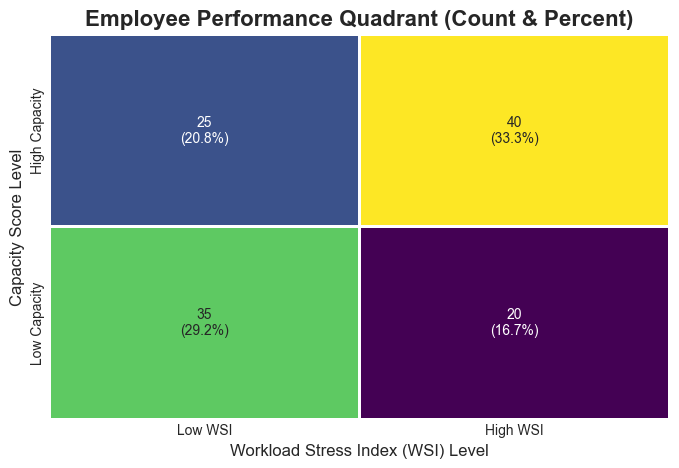

WSI Level,Low WSI,High WSI
Capacity Level,,
High Capacity,25\n(20.8%),40\n(33.3%)
Low Capacity,35\n(29.2%),20\n(16.7%)



--- Quadrant Analysis for SG-A and SG-C Only ---
✅ Plot saved to: quadrant_filtered_groups.png


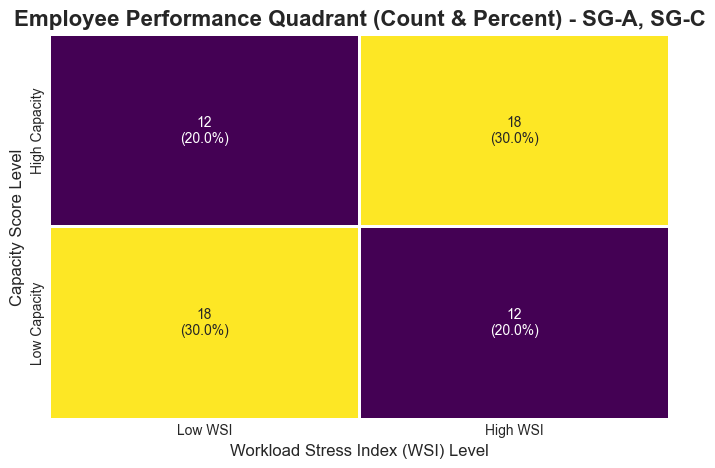

WSI Level,Low WSI,High WSI
Capacity Level,,
High Capacity,12\n(20.0%),18\n(30.0%)
Low Capacity,18\n(30.0%),12\n(20.0%)


In [13]:
# --- 📊 2x2 Performance Quadrant Analysis (Now saves the plots) ---
print("This analysis segments employees into four performance categories based on their Capacity and WSI scores.")

def create_performance_quadrant(alias_metrics_df, group_filter=None, save_path: Optional[str] = None):
    df = alias_metrics_df.copy()
    if group_filter:
        df = df[df['StaffGroup'].isin(group_filter)]

    if df.empty:
        print("No data for the selected filter.")
        return pd.DataFrame(), None # Return None for the path

    cap_median = df['Capacity_Score_0_100'].median()
    wsi_median = df['WSI_0_100'].median()

    # Create separate columns for the 2x2 grid
    df['Capacity Level'] = np.where(df['Capacity_Score_0_100'] >= cap_median, 'High Capacity', 'Low Capacity')
    df['WSI Level'] = np.where(df['WSI_0_100'] >= wsi_median, 'High WSI', 'Low WSI')

    # Create the 2x2 grid of counts and percentages
    count_table = pd.crosstab(df['Capacity Level'], df['WSI Level'])
    if 'Low WSI' in count_table.columns:
        count_table = count_table[['Low WSI', 'High WSI']]
    percent_table = (count_table / len(df) * 100).round(1)
    annot_table = count_table.astype(str) + "\n(" + percent_table.astype(str) + "%)"

    # Visualization: Heatmap of the 2x2 Grid
    plt.figure(figsize=(8, 5))
    sns.heatmap(
        count_table,
        annot=annot_table,
        fmt='s',
        cmap="viridis",
        cbar=False,
        linewidths=2,
        linecolor='white'
    )
    title = 'Employee Performance Quadrant (Count & Percent)'
    if group_filter:
        title += f" - {', '.join(group_filter)}"
    plt.title(title, fontsize=16, weight='bold')
    plt.ylabel('Capacity Score Level', fontsize=12)
    plt.xlabel('Workload Stress Index (WSI) Level', fontsize=12)
    
    # --- ADDED SAVE LOGIC ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"✅ Plot saved to: {save_path}")

    plt.show()

    # Return the formatted table and the path to the saved image
    return annot_table, save_path

# --- Run the Analysis for ALL Groups ---
print("\n--- Quadrant Analysis for ALL Groups ---")
quadrant_all_path = "quadrant_all_groups.png"
wsi_capacity_quadrant_all, path1 = create_performance_quadrant(latest_month_df, save_path=quadrant_all_path)
if path1:
    saved_plots["[INSERT QUADRANT PLOT ALL GROUPS HERE]"] = path1
display(wsi_capacity_quadrant_all)


# --- Run for a specific subset of groups ---
print("\n--- Quadrant Analysis for SG-A and SG-C Only ---")
quadrant_filtered_path = "quadrant_filtered_groups.png"
wsi_capacity_quadrant_filtered, path2 = create_performance_quadrant(latest_month_df, group_filter=['SG-A', 'SG-C'], save_path=quadrant_filtered_path)
if path2:
    saved_plots["[INSERT QUADRANT PLOT FILTERED HERE]"] = path2
display(wsi_capacity_quadrant_filtered)


--- Business Goals for Optimization ---
{'WSI_0_100': -1.0, 'efficiency': 0.6, 'days_to_close': -0.6, 'backlog': -0.8, 'numCases': 0.25}

--- Recommended Reassignment Plan ---


,alias,from_group,to_group
0,SG-C-E18,SG-C,SG-A
1,SG-B-E30,SG-B,SG-C


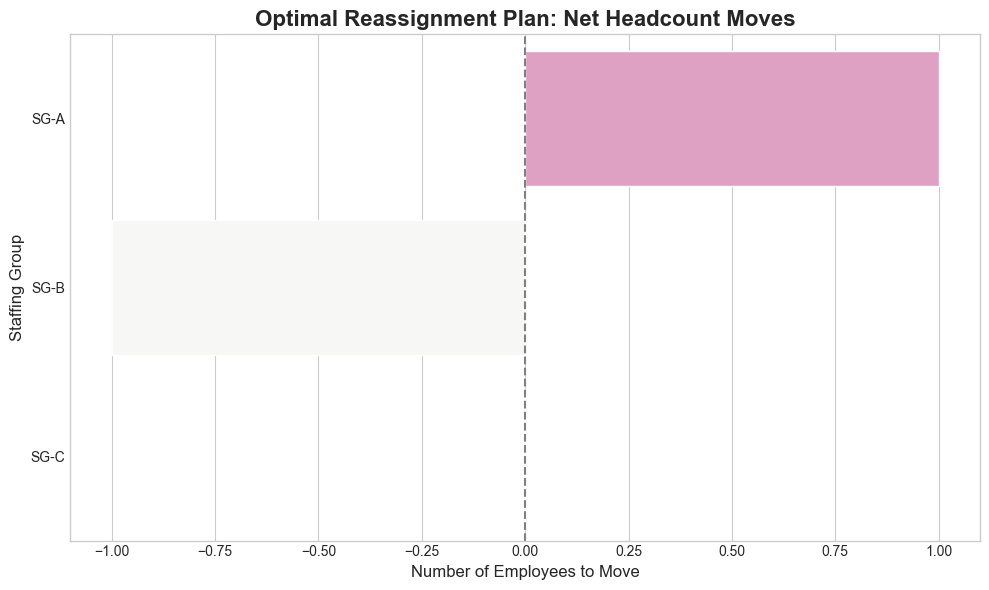


--- Projected Metrics: Initial vs. Optimized State ---


,StaffGroup,Headcount_Initial,Capacity_Score_0_100_Initial,WSI_0_100_Initial,efficiency_Initial,days_to_close_Initial,backlog_Initial,numCases_Initial,efficiency_pred,days_to_close_pred,backlog_pred,Headcount_Optimized,Capacity_Score_0_100_Optimized,WSI_0_100_Optimized,efficiency_Optimized,days_to_close_Optimized,backlog_Optimized,numCases_Optimized
0,SG-A,30,0.06,13.23,0.77,8.53,657,1215,0.69,9.46,25.92,31,0.07,13.55,0.70,9.03,25.73,1271
1,SG-B,30,0.01,17.55,0.77,7.12,593,1263,0.78,7.90,20.39,29,0.02,17.77,0.78,8.17,19.97,1235
2,SG-C,30,0.02,14.65,0.79,7.50,537,1179,0.81,6.86,17.82,30,0.01,13.32,0.80,7.30,17.14,1151
3,SG-D,30,0.04,13.82,0.77,8.47,576,1235,0.71,10.91,26.92,30,0.04,13.82,0.71,10.91,26.92,1235


In [21]:
print("--- Business Goals for Optimization ---")
# We've told the system that reducing WSI and backlog is most important.
print(opt_cfg.objective_weights)

# --- Run the Optimizer ---
optimizer = Optimizer(engine=engine, cfg=opt_cfg)
plan_output = optimizer.optimize_reassignment(df_month)

print("\n--- Recommended Reassignment Plan ---")
# The table below lists the exact moves to make to achieve a more optimal state.
plan_df = pd.DataFrame(plan_output['plan'])
optimizer_plan_path = "optimizer_plan.png" # Define path

display(plan_df)
plot_optimization_plan(plan_output['plan'])


print("\n--- Projected Metrics: Initial vs. Optimized State ---")
# This table compares the average team metrics before and after the recommended moves.
comparison = plan_output['initial_metrics'].merge(
    plan_output['expected_metrics'],
    on='StaffGroup',
    suffixes=('_Initial', '_Optimized')
)
display(comparison)

In [23]:
# --- 🚀 Final Step (Text-Only Summary): Generate and Call LLM ---

# --- 🚀 UPDATED Function (Text-Only Summary): Generate and Call LLM ---

def generate_llm_text_prompt(
    team_metrics_df,
    scorer_obj,
    sim_data_df,
    opt_plan_obj,
    bucket_uplift_df,
    quadrant_df,
    wsi_config,
    opt_config,
    # --- FIX: Add the new dataframe as an argument ---
    post_volume_df 
):
    """
    Takes ALL notebook outputs and configs, and compiles them into a detailed
    text prompt that instructs the LLM to explain methodologies and summarize results.
    """
    # Convert all relevant DataFrames to a readable markdown format
    team_metrics_md = team_metrics_df.to_markdown(index=False)
    feature_importance_md = scorer_obj.feature_importances().to_markdown(index=False)
    simulation_md = sim_data_df.reset_index().to_markdown(index=False)
    opt_plan_md = pd.DataFrame(opt_plan_obj['plan']).to_markdown(index=False)
    opt_expected_md = opt_plan_obj['expected_metrics'].to_markdown(index=False)
    bucket_uplift_md = bucket_uplift_df.to_markdown(index=False)
    quadrant_md = quadrant_df.to_markdown()
    wsi_weights_md = pd.DataFrame(wsi_config.weights.items(), columns=['Component', 'Weight']).to_markdown(index=False)
    opt_weights_md = pd.DataFrame(opt_config.objective_weights.items(), columns=['Metric', 'Weight']).to_markdown(index=False)
    # --- FIX: Add the new dataframe to the markdown conversion ---
    post_volume_md = post_volume_df[['numCases']].describe().to_markdown()

    prompt = f"""
You are an expert business analyst and communicator. Your task is to generate a detailed business analysis report for executive stakeholders who are not data scientists. For each section, you must first **explain the methodology** in simple, non-technical terms, and then **summarize the key findings** from the data provided for that section.

--- DATA AND INSTRUCTIONS ---

### 1. The Capacity Score & WSI (No Change)
**Your Task:** First, explain how the Capacity Score and WSI are calculated. Then, explain the key drivers and summarize team performance.
**Data:**
*Feature Importance:*
{feature_importance_md}
*Team Performance Metrics:*
{team_metrics_md}
*WSI Component Weights:*
{wsi_weights_md}

### 2. "What-If" Headcount Simulation (No Change)
**Your Task:** Explain the simulation and summarize the projected impact of the specific moves.
**Data:**
*Simulation Results:*
{simulation_md}

### 3. Bucket Uplift & Overall Volume Impact (UPDATED SECTION)
**Your Task:**
- Explain the "Bucket Uplift" analysis and state the total estimated incremental cases.
- Then, explain the "Overall Volume Impact" simulation, which shows how the total distribution of 'numCases' would shift if a percentage of staff were uplifted. Summarize the change in the mean `numCases`.
**Data:**
*Bucket Uplift Summary:*
{bucket_uplift_md}
*Overall Volume Impact (Post-Simulation 'numCases' stats):*
{post_volume_md}

### 4. Optimal Headcount Reassignment (No Change)
**Your Task:** Explain how the Optimizer works, present the recommended plan, and summarize expected improvements.
**Data:**
*Optimizer Business Goals (Objective Weights):*
{opt_weights_md}
*Recommended Moves:*
{opt_plan_md}
*Expected State Metrics:*
{opt_expected_md}

### 5. Performance Quadrant Analysis (No Change)
**Your Task:** Explain the four quadrants and summarize the employee distribution.
**Data:**
*2x2 Performance Quadrant Grid:*
{quadrant_md}

--- END OF DATA ---

Now, generate the full, detailed business analysis report based on these instructions and data.
"""
    return prompt

# --- 🚀 Call the UPDATED functions ---

# 1. Call for the text-only summary
final_prompt_explained = generate_llm_text_prompt(
    team_metrics_df=team_metrics,
    scorer_obj=scorer,
    sim_data_df=stacked_sim_data,
    opt_plan_obj=plan_output,
    bucket_uplift_df=bucket_uplift_summary,
    quadrant_df=wsi_capacity_quadrant_all,
    wsi_config=wsi_cfg,
    opt_config=opt_cfg,
    # --- FIX: Pass the new dataframe ---
    post_volume_df=post_volume_df
)



# # --- FIX: Add the new placeholders and paths to your saved_plots dictionary ---
# # This dictionary should already contain your other plot paths.
# saved_plots["[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]"] = simulation_dist_path
# saved_plots["[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]"] = volume_dist_path

# # 3. Generate the final HTML (Your create_html_report_final function is fine as is)
# # llm_text_with_placeholders = YOUR_LLM_API_CALL(final_placeholder_prompt)
# # create_html_report_final(llm_text_with_placeholders, saved_plots)

# print("✅ All LLM functions and plot dictionaries are now fully updated.")

# print("✅ Final LLM prompt with detailed explanation instructions has been generated.")

# # --- Send prompt to your chosen LLM and print the response ---
# # llm_text_response = ... (Your code to call the LLM API)
# # print(llm_text_response)

# # --- 🚀 Final Step (HTML Report): Generate and Infuse Plots ---
import base64
# --- 🚀 UPDATED Function (HTML Report): Generate and Infuse Plots ---


def generate_llm_placeholder_prompt(
    team_metrics_df,
    scorer_obj,
    sim_data_df,
    opt_plan_obj,
    bucket_uplift_df,
    quadrant_df,
    wsi_config,
    opt_config,
    post_volume_df # Add the new dataframe
):
    """
    Generates a prompt that instructs the LLM to create a detailed narrative
    and insert placeholders where all the plots should go, providing full context.
    """
    # FIX: Convert all dataframes to markdown to give the LLM full context
    team_metrics_md = team_metrics_df.to_markdown(index=False)
    feature_importance_md = scorer_obj.feature_importances().to_markdown(index=False)
    simulation_md = sim_data_df.reset_index().to_markdown(index=False)
    opt_plan_md = pd.DataFrame(opt_plan_obj['plan']).to_markdown(index=False)
    opt_expected_md = opt_plan_obj['expected_metrics'].to_markdown(index=False)
    bucket_uplift_md = bucket_uplift_df.to_markdown(index=False)
    quadrant_md = quadrant_df.to_markdown()
    wsi_weights_md = pd.DataFrame(wsi_config.weights.items(), columns=['Component', 'Weight']).to_markdown(index=False)
    opt_weights_md = pd.DataFrame(opt_config.objective_weights.items(), columns=['Metric', 'Weight']).to_markdown(index=False)
    post_volume_md = post_volume_df[['numCases']].describe().to_markdown()

    # --- FIX: Add all new placeholder tags to the instruction list ---
    prompt = f"""
You are an expert business analyst creating a detailed executive summary report. Your task is to analyze the provided data, explain the methodologies, summarize the key findings, and write a clear narrative.

Your response MUST include the following placeholder tags exactly as written where each chart should appear:
- [INSERT SCORE DISTRIBUTION PLOT HERE]
- [INSERT TEAM METRICS PLOT HERE]
- [INSERT FEATURE IMPORTANCE PLOT HERE]
- [INSERT CONTRIBUTION WATERFALL PLOT HERE]
- [INSERT SIMULATION HEATMAP HERE]
- [INSERT SIMULATION DISTRIBUTIONS PLOT HERE]
- [INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]
- [INSERT OPTIMIZER PLAN PLOT HERE]
- [INSERT QUADRANT PLOT ALL GROUPS HERE]

**Task:**
Write a summary that flows logically through the analysis. For each section, first explain the methodology in simple terms, then summarize the key findings from the data provided, and finally insert the corresponding placeholder tag for the visualization.

--- DATA AND INSTRUCTIONS ---

### 1. The Capacity Score & WSI
**Analysis:** Explain the scores, their drivers, and summarize team performance.
- Insert [INSERT SCORE DISTRIBUTION PLOT HERE] and [INSERT TEAM METRICS PLOT HERE] in your summary.
**Data:**
*Feature Importance:*
{feature_importance_md}
*Team Performance Metrics:*
{team_metrics_md}
*WSI Component Weights:*
{wsi_weights_md}

### 2. "What-If" Headcount Simulation
**Analysis:** Explain the simulation, summarize the team-level impact, and discuss the shift in employee distributions.
- Insert [INSERT SIMULATION HEATMAP HERE] for the team summary.
- Insert [INSERT SIMULATION DISTRIBUTIONS PLOT HERE] to show the employee-level impact.
**Data:**
*Simulation Results (Pre vs. Post):*
{simulation_md}

### 3. Bucket Uplift & Overall Volume Impact
**Analysis:** Explain the rule-based "Bucket Uplift" estimation and state the total incremental cases. Then, explain the "Overall Volume Impact" simulation and summarize the change in the 'numCases' distribution.
- Insert [INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE] to visualize the volume shift.
**Data:**
*Bucket Uplift Summary:*
{bucket_uplift_md}
*Overall Volume Impact (Post-Simulation 'numCases' stats):*
{post_volume_md}

### 4. Optimal Headcount Reassignment
**Analysis:** Explain the Optimizer, present the recommended plan, and summarize expected improvements.
- Insert [INSERT OPTIMIZER PLAN PLOT HERE] for the net moves visual.
**Data:**
*Optimizer Business Goals:*
{opt_weights_md}
*Recommended Moves:*
{opt_plan_md}
*Expected Metrics After Moves:*
{opt_expected_md}

### 5. Performance Quadrant Analysis
**Analysis:** Explain the four quadrants and summarize the employee distribution.
- Insert [INSERT QUADRANT PLOT ALL GROUPS HERE] for the 2x2 grid visual.
**Data:**
*2x2 Performance Quadrant Grid:*
{quadrant_md}

--- END OF DATA ---
"""
    return prompt

# --- 🚀 Final Step (HTML Report): Generate and Infuse All Plots ---
import base64
import markdown # You may need to run: !pip install markdown

# --- 1. Get the text response from the LLM (same as before) ---
# For this example, we'll use a sample LLM response with ALL placeholders.
# llm_text_with_placeholders = ... (Your code to call the LLM API)

# llm_text_with_placeholders = """
# ### Score Distributions and Team Trends
# This analysis begins by looking at the overall distribution of the **Capacity Score** and **Workload Stress Index (WSI)** across all employees.
# [INSERT SCORE DISTRIBUTION PLOT HERE]

# The team metrics plot shows how each staff group has trended over time on key indicators.
# [INSERT TEAM METRICS PLOT HERE]

# ### Score Drivers
# The primary factors influencing the Capacity Score are identified below.
# [INSERT FEATURE IMPORTANCE PLOT HERE]
# For a specific employee, we can see a detailed breakdown of their score.
# [INSERT CONTRIBUTION WATERFALL PLOT HERE]

# ### Scenario and Optimization Analysis
# We simulated moving employees to see the impact. The heatmap shows the projected changes.
# [INSERT SIMULATION HEATMAP HERE]

# The optimizer then provides a concrete plan for reassignment based on our business goals.
# [INSERT OPTIMIZER PLAN PLOT HERE]

# ### Performance Segmentation
# Finally, employees are segmented into four performance quadrants.
# [INSERT QUADRANT PLOT ALL GROUPS HERE]
# """

# --- 🚀 Call the UPDATED functions ---

# 1. Call for the text-only summary
final_prompt_explained = generate_llm_text_prompt(
    team_metrics_df=team_metrics,
    scorer_obj=scorer,
    sim_data_df=stacked_sim_data,
    opt_plan_obj=plan_output,
    bucket_uplift_df=bucket_uplift_summary,
    quadrant_df=wsi_capacity_quadrant_all,
    wsi_config=wsi_cfg,
    opt_config=opt_cfg,
    # --- FIX: Pass the new dataframe ---
    post_volume_df=post_volume_df
)

# 2. Call for the HTML report narrative
final_placeholder_prompt = generate_llm_placeholder_prompt(
    team_metrics_df=team_metrics,
    scorer_obj=scorer,
    sim_data_df=stacked_sim_data,
    opt_plan_obj=plan_output,
    bucket_uplift_df=bucket_uplift_summary,
    quadrant_df=wsi_capacity_quadrant_all,
    wsi_config=wsi_cfg,
    opt_config=opt_cfg,
    # --- FIX: Add the missing dataframe argument here ---
    post_volume_df=post_volume_df
)

# --- FIX: Add the new placeholders and paths to your saved_plots dictionary ---
# This dictionary should already contain your other plot paths from previous cells.
saved_plots["[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]"] = simulation_dist_path
saved_plots["[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]"] = volume_dist_path


# 3. Generate the final HTML (Your create_html_report_final function is correct)
# llm_text_with_placeholders = YOUR_LLM_API_CALL(final_placeholder_prompt)
# create_html_report_final(llm_text_with_placeholders, saved_plots)

print("✅ All LLM functions and plot dictionaries are now fully updated.")


✅ All LLM functions and plot dictionaries are now fully updated.


In [17]:
# 1. Install the library (run this once)
# !pip install openai

import openai
import os

# 2. Set up your API key
# (Best practice is to set this as an environment variable)
# openai.api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = "ENTER API KEY HERE"

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")  # optional; only if you use the LLM section

# 3. Send the prompt to the model
response = openai.chat.completions.create(
  model="gpt-5", # Or "gpt-3.5-turbo"
  messages=[
    {"role": "system", "content": "You are a expert business analyst for Microsoft Azure customer support."},
    {"role": "user", "content": final_prompt_explained}
  ]
)

# 4. Print the executive summary
print("--- 🚀 Executive Summary ---")
print(response.choices[0].message.content)

--- 🚀 Executive Summary ---
Executive Business Analysis Report

1) Capacity Score and WSI

How we calculate it (plain language)
- Capacity Score (0–100): This is a forward-looking estimate of how much workload an agent or team can handle next, based on recent signals. We train a model that learns which factors matter most when capacity changes. A higher score means more available capacity; a lower score means the team is closer to being fully utilized.
- What drives the Capacity Score: The model’s feature importance tells us which inputs influence the score the most. In this period:
  - TimeSpent (most influential)
  - numOpenCases
  - backlog
  - numCases
  - som (minor influence)
  - Other listed features contributed no measurable signal in this period.
- WSI (Workload/Stress Index, 0–100): This combines several operational components into a single index using fixed weights:
  - cap_dev (capacity deviation from desired level): weight 0.4
  - persist (persistence of elevated load): we

In [26]:
# --- 🚀 Final Step (HTML Report): Generate LLM Narrative and Infuse Plots ---
import base64
import markdown # You may need to run: !pip install markdown

def generate_llm_placeholder_prompt(
    team_metrics_df,
    scorer_obj,
    sim_data_df,
    opt_plan_obj,
    bucket_uplift_df,
    quadrant_df,
    wsi_config,
    opt_config
):
    """
    Generates a prompt that instructs the LLM to create a detailed narrative
    and insert placeholders where the plots should go.
    """
    # Convert all relevant DataFrames to a readable markdown format for the LLM's analysis
    team_metrics_md = team_metrics_df.to_markdown(index=False)
    feature_importance_md = scorer_obj.feature_importances().to_markdown(index=False)
    simulation_md = sim_data_df.reset_index().to_markdown(index=False)
    opt_plan_md = pd.DataFrame(opt_plan_obj['plan']).to_markdown(index=False)
    opt_expected_md = opt_plan_obj['expected_metrics'].to_markdown(index=False)
    bucket_uplift_md = bucket_uplift_df.to_markdown(index=False)
    quadrant_md = quadrant_df.to_markdown()
    wsi_weights_md = pd.DataFrame(wsi_config.weights.items(), columns=['Component', 'Weight']).to_markdown(index=False)
    opt_weights_md = pd.DataFrame(opt_config.objective_weights.items(), columns=['Metric', 'Weight']).to_markdown(index=False)

    prompt = f"""
You are an expert business analyst writing a detailed report for executive stakeholders. Your task is to explain the methodology and summarize the key findings for each section of a capacity analysis.

Your response MUST include the following placeholder tags exactly as written in your final narrative where each chart should appear:
- [INSERT SCORE DISTRIBUTION PLOT HERE]
- [INSERT TEAM METRICS PLOT HERE]
- [INSERT FEATURE IMPORTANCE PLOT HERE]
- [INSERT CONTRIBUTION WATERFALL PLOT HERE]
- [INSERT SIMULATION HEATMAP HERE]
- [INSERT OPTIMIZER PLAN PLOT HERE]
- [INSERT QUADRANT PLOT ALL GROUPS HERE]

--- DATA AND INSTRUCTIONS ---

### 1. The Capacity Score & WSI
**Your Task:**
- First, explain how the Capacity Score and WSI are calculated in simple terms.
- For WSI, provide a hypothetical example of the calculation.
- Summarize the team performance based on the metrics table.
- In your summary, reference the employee score distributions by inserting the placeholder: [INSERT SCORE DISTRIBUTION PLOT HERE]
- Reference the team trends over time by inserting the placeholder: [INSERT TEAM METRICS PLOT HERE]
**Data:**
*Team Performance Metrics:*
{team_metrics_md}
*WSI Component Weights:*
{wsi_weights_md}

### 2. Score Drivers
**Your Task:**
- Explain what the key global drivers of the Capacity Score are.
- Explain how the waterfall chart breaks down the score for a single employee.
- Insert the placeholder [INSERT FEATURE IMPORTANCE PLOT HERE] for the global drivers chart.
- Insert the placeholder [INSERT CONTRIBUTION WATERFALL PLOT HERE] for the employee-specific chart.
**Data:**
*Feature Importance:*
{feature_importance_md}

### 3. "What-If" Headcount Simulation
**Your Task:**
- Explain how the simulation works (re-running the pipeline and models).
- Summarize the projected impact of the moves.
- Insert the placeholder [INSERT SIMULATION HEATMAP HERE] to show the visual comparison.
**Data:**
*Simulation Results (Pre vs. Post):*
{simulation_md}

### 4. Bucket Uplift Analysis
**Your Task:**
- Explain this rule-based estimation for incremental case handling.
- State the total estimated incremental cases from the table.
**Data:**
*Bucket Uplift Summary:*
{bucket_uplift_md}

### 5. Optimal Headcount Reassignment
**Your Task:**
- Explain how the Optimizer works based on the business goals (weights).
- Present the recommended move plan.
- Summarize the expected improvements.
- Insert the placeholder [INSERT OPTIMIZER PLAN PLOT HERE] to show the net moves.
**Data:**
*Optimizer Business Goals:*
{opt_weights_md}
*Recommended Moves:*
{opt_plan_md}
*Expected Metrics After Moves:*
{opt_expected_md}

### 6. Performance Quadrant Analysis
**Your Task:**
- Explain the four quadrants (Ideal, Overworked, etc.).
- Summarize the employee distribution based on the data.
- Insert the placeholder [INSERT QUADRANT PLOT ALL GROUPS HERE] for the 2x2 grid visual.
**Data:**
*2x2 Performance Quadrant Grid:*
{quadrant_md}

--- END OF DATA ---

Now, generate the full, detailed business analysis report, including all text explanations and all placeholder tags in the correct locations.
"""
    return prompt

def create_html_report_final(
    # FIX: Add a new argument for the executive summary text
    executive_summary,
    # FIX: Rename this for clarity
    llm_placeholder_text,
    plot_paths,
    output_filename="Executive_Summary_Final.html"
):
    """
    Takes the executive summary, the placeholder narrative, and plot paths
    to generate a self-contained HTML report.
    """
    # FIX: Convert both text inputs to HTML
    summary_html = markdown.markdown(executive_summary)
    plots_narrative_html = markdown.markdown(llm_placeholder_text)

    # This loop replaces placeholders in the plot narrative with the actual images
    for placeholder, path in plot_paths.items():
        try:
            with open(path, "rb") as image_file:
                encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            plot_title = placeholder.strip('[]').replace('INSERT', '').replace('PLOT HERE', '').replace('_', ' ').strip().title()
            img_tag = f'<h3>{plot_title}</h3><img src="data:image/png;base64,{encoded_string}">'
            # FIX: Replace placeholders in the correct HTML block
            plots_narrative_html = plots_narrative_html.replace(placeholder, img_tag)
        except (FileNotFoundError, TypeError):
            plots_narrative_html = plots_narrative_html.replace(placeholder, f"<p><i><b>Warning:</b> Image file not found at {path}.</i></p>")

    html_content = f"""
    <html>
    <head>
        <title>Executive Summary</title>
        <style>
            body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif; line-height: 1.6; padding: 25px; max-width: 960px; margin: auto; color: #333; }}
            h1, h2, h3 {{ color: #2a2a2a; border-bottom: 1px solid #eee; padding-bottom: 5px; margin-top: 30px;}}
            h1 {{ text-align: center; border-bottom: 2px solid #333; }}
            hr {{ border: 0; border-top: 1px solid #eee; margin: 40px 0; }}
            img {{ max-width: 100%; height: auto; border: 1px solid #ddd; border-radius: 4px; margin: 20px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }}
            p, li {{ font-size: 16px; }}
            ul {{ padding-left: 20px; }}
            table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #f4f4f4; }}
        </style>
    </head>
    <body>
        <h1>Executive Summary: Capacity & Workload Analysis</h1>
        
        {summary_html}
        
        <hr>
        
        {plots_narrative_html}
    </body>
    </html>
    """
    
    with open(output_filename, "w", encoding='utf-8') as f:
        f.write(html_content)
        
    print(f"✅ Report successfully generated: {output_filename}")

llm_text_with_placeholders = """
### 1. Capacity Score & WSI
This analysis introduces two key metrics: the **Capacity Score**, a 0-100 machine learning-based measure of an employee's performance against their team's benchmark, and the **Workload Stress Index (WSI)**, a 0-100 composite score of workload pressure.
[INSERT SCORE DISTRIBUTION PLOT HERE]

Team trends show that while overall stress has decreased since June, capacity deviation has become negative for several teams, indicating a new area for focus.
[INSERT TEAM METRICS PLOT HERE]

### 2. Score Drivers
The primary factors influencing the Capacity Score are **numCases, backlog, numOpenCases,** and **TimeSpent**.
[INSERT FEATURE IMPORTANCE PLOT HERE]
For individual employees, we can see a detailed breakdown of their score.
[INSERT CONTRIBUTION WATERFALL PLOT HERE]

### 3. "What-If" Headcount Simulation
We simulated moving employees between teams to project the impact on key metrics. The heatmap below shows the team-level changes.
[INSERT SIMULATION HEATMAP HERE]

At the employee level, we can see how this move shifts the overall distributions of key metrics like capacity and efficiency for the entire population involved.
[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]

### 4. Bucket Uplift & Overall Volume Impact
This analysis estimates that if we can uplift a small percentage of employees from lower-performing buckets, we could handle a significant number of additional cases. The plot below shows how this uplift would shift the entire organization's `numCases` distribution.
[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]

### 5. Optimal Headcount Reassignment
The Optimizer suggests a targeted plan to maximize our business goals, such as reducing backlog and WSI.
[INSERT OPTIMIZER PLAN PLOT HERE]

### 6. Performance Quadrant Analysis
Finally, employees are segmented into four performance categories based on their capacity and stress levels.
[INSERT QUADRANT PLOT ALL GROUPS HERE]
"""


# # --- FIX: Ensure all plot paths are in the dictionary ---

# # This dictionary collects all the plot filenames generated throughout the notebook.
# # The keys MUST EXACTLY match the placeholders you gave the LLM.
# saved_plots = {
#     "[INSERT SCORE DISTRIBUTION PLOT HERE]": score_dist_path,
#     "[INSERT TEAM METRICS PLOT HERE]": team_metrics_path,
#     "[INSERT FEATURE IMPORTANCE PLOT HERE]": feature_importance_path,
#     "[INSERT CONTRIBUTION WATERFALL PLOT HERE]": contributions_path,
#     "[INSERT SIMULATION HEATMAP HERE]": simulation_heatmap_path,
#     "[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]": simulation_dist_path,
#     "[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]": volume_dist_path,
#     "[INSERT OPTIMIZER PLAN PLOT HERE]": optimizer_plan_path,
#     "[INSERT QUADRANT PLOT ALL GROUPS HERE]": quadrant_all_path
# }

# print("✅ 'saved_plots' dictionary is now complete with all 9 plot paths.")


# # 4. Generate the final HTML report with all plots infused
# create_html_report_final(llm_text_with_placeholders, saved_plots)

# print("\n✅ All LLM functions and plot dictionaries are now fully updated and the HTML report has been generated.")


# --- Get the executive summary text from the LLM response ---
executive_summary_text = response.choices[0].message.content

# --- This is your existing text with placeholders for the plots ---
llm_text_with_placeholders = """
### Detailed Analysis & Visualizations

This section provides the visual charts that support the executive summary above.
[INSERT SCORE DISTRIBUTION PLOT HERE]
[INSERT TEAM METRICS PLOT HERE]
[INSERT FEATURE IMPORTANCE PLOT HERE]
[INSERT CONTRIBUTION WATERFALL PLOT HERE]
[INSERT SIMULATION HEATMAP HERE]
[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]
[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]
[INSERT OPTIMIZER PLAN PLOT HERE]
[INSERT QUADRANT PLOT ALL GROUPS HERE]
"""

saved_plots = {
    "[INSERT SCORE DISTRIBUTION PLOT HERE]": score_dist_path,
    "[INSERT TEAM METRICS PLOT HERE]": team_metrics_path,
    "[INSERT FEATURE IMPORTANCE PLOT HERE]": feature_importance_path,
    "[INSERT CONTRIBUTION WATERFALL PLOT HERE]": contributions_path,
    "[INSERT SIMULATION HEATMAP HERE]": simulation_heatmap_path,
    "[INSERT SIMULATION DISTRIBUTIONS PLOT HERE]": simulation_dist_path,
    "[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]": volume_dist_path,
    "[INSERT OPTIMIZER PLAN PLOT HERE]": optimizer_plan_path,
    "[INSERT QUADRANT PLOT ALL GROUPS HERE]": quadrant_all_path
}


create_html_report_final(
    executive_summary=executive_summary_text,
    llm_placeholder_text=llm_text_with_placeholders,
    plot_paths=saved_plots
)





# --- 3. Generate the final HTML report with plots infused ---
# create_html_report_final(llm_text_with_placeholders, saved_plots)

✅ Report successfully generated: Executive_Summary_Final.html
